In [5]:
import plenoptic as po
import re
import numpy as np
import matplotlib.pyplot as plt
import pyrtools as pt
import imageio
import torch
import seaborn as sns
import foveated_metamers as fov

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
met = po.synth.Metamer.load('/home/billbrod/Desktop/metamers/metamers/V1_cone-1.0_norm_s6_gaussian/tiles_range-.05,.95_size-1024,1024/scaling-0.5/opt-Adam/fr-0_lc-1_cf-0.01_clamp-True/seed-0_init-white_lr-0.1_e0-0.5_em-12_iter-5000_thresh-1e-08_gpu-1.pt',
                            po.simul.PrimaryVisualCortex.from_state_dict_reduced)
met_cont = po.synth.Metamer.load('/home/billbrod/Desktop/metamers/metamers_continue/V1_cone-1.0_norm_s6_gaussian/tiles_range-.05,.95_size-1024,1024/scaling-0.5/opt-Adam/fr-0_lc-1_cf-0.01_clamp-True/attempt-0_iter-5000/seed-0_init-white_lr-0.1_e0-0.5_em-12_iter-5000_thresh-1e-08_gpu-1.pt',
                            po.simul.PrimaryVisualCortex.from_state_dict_reduced)
met_long = po.synth.Metamer.load('/home/billbrod/Desktop/metamers/metamers/V1_cone-1.0_norm_s6_gaussian/tiles_range-.05,.95_size-1024,1024/scaling-0.5/opt-Adam/fr-0_lc-1_cf-0.01_clamp-True/seed-0_init-white_lr-1_e0-0.5_em-12_iter-10000_thresh-1e-08_gpu-1.pt',
                            po.simul.PrimaryVisualCortex.from_state_dict_reduced)

/home/billbrod/Documents/plenoptic/plenoptic/simulate/canonical_computations/pooling_windows.py:438: UserWarning: Loading windows from cache: /home/billbrod/Desktop/metamers/windows_cache/scaling-0.5_size-1024,1024_e0-0.500_em-12.0_w-1.0_gaussian.pt
  warnings.warn("Loading windows from cache: %s" % self.cache_paths[-1])
/home/billbrod/Documents/plenoptic/plenoptic/simulate/canonical_computations/pooling_windows.py:438: UserWarning: Loading windows from cache: /home/billbrod/Desktop/metamers/windows_cache/scaling-0.5_size-512,512_e0-0.500_em-12.0_w-1.0_gaussian.pt
  warnings.warn("Loading windows from cache: %s" % self.cache_paths[-1])
/home/billbrod/Documents/plenoptic/plenoptic/simulate/canonical_computations/pooling_windows.py:438: UserWarning: Loading windows from cache: /home/billbrod/Desktop/metamers/windows_cache/scaling-0.5_size-256,256_e0-0.500_em-12.0_w-1.0_gaussian.pt
  warnings.warn("Loading windows from cache: %s" % self.cache_paths[-1])
/home/billbrod/Documents/plenoptic/

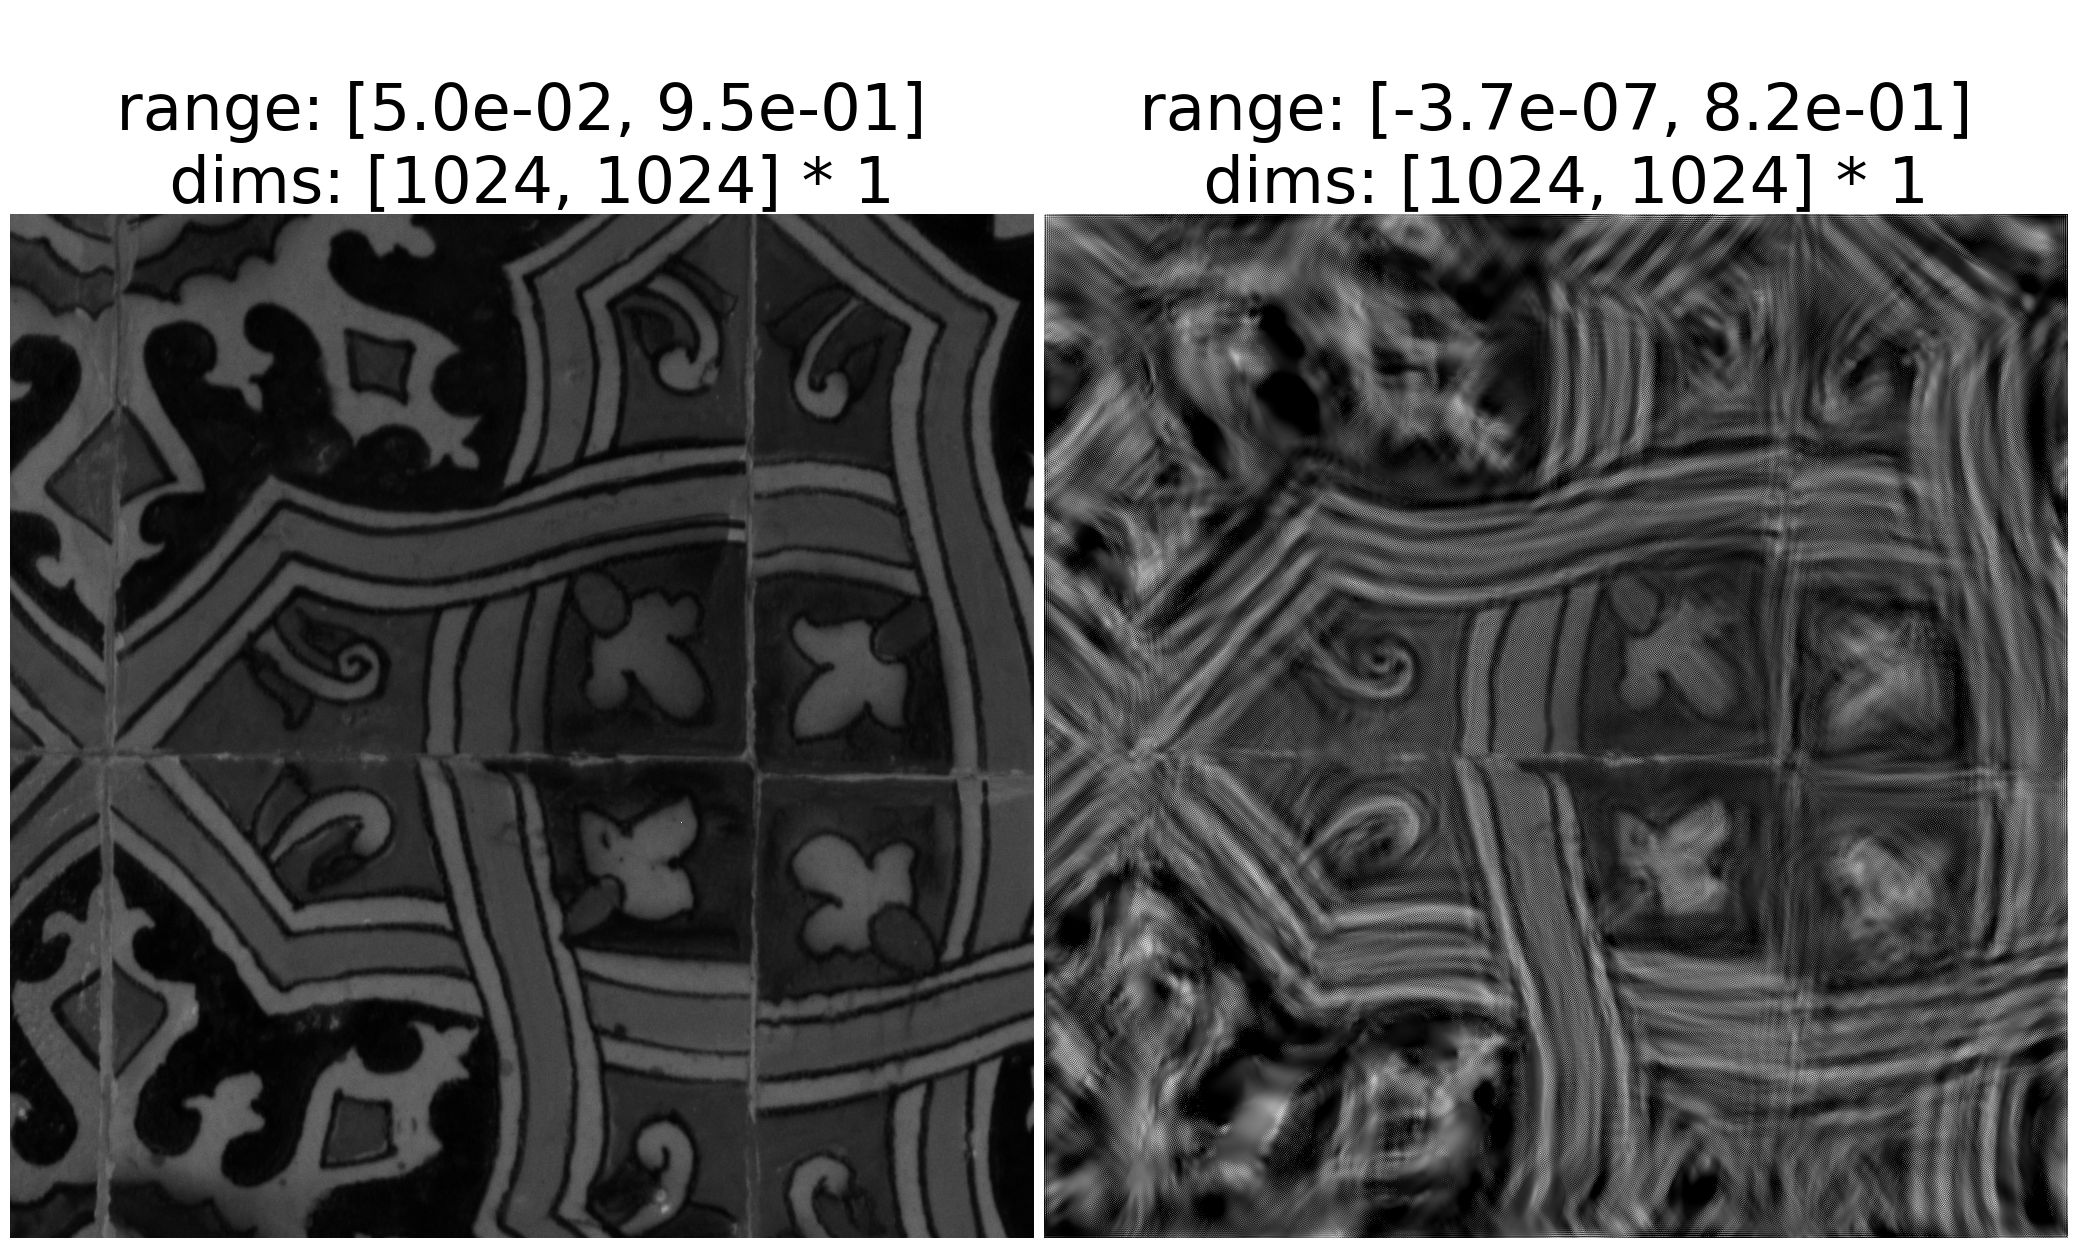

In [9]:
fig = pt.imshow([met.target_image.squeeze(), met.matched_image.squeeze()], zoom=1)
#fig.savefig('/home/billbrod/Desktop/metamers/metamers/V1_cone-1.0_norm_s6_gaussian/tiles_range-.05,.95_size-1024,1024/scaling-0.5/opt-Adam/fr-0_lc-1_cf-0.01_none-False/noclamp.png')

In [118]:
norm_dict = met.model.normalize_dict.copy()
met.model.normalize_dict = {}

target_rep = met.model(met.target_image)
matched_rep = met.model(met.matched_image)
matched_rep_cont = met.model(met_cont.matched_image)
matched_rep_long = met.model(met_long.matched_image)

In [120]:
# error = met.representation_error()
error = target_rep - matched_rep
error_cont = target_rep - matched_rep_cont
error_long = target_rep - matched_rep_long
error = met.model._representation_for_plotting(data=error)
error_cont = met.model._representation_for_plotting(data=error_cont)
error_long = met.model._representation_for_plotting(data=error_long)

In [132]:
normalized_error = {}
for k, v in error.items():
    if isinstance(k, str):
        normalized_error[k] = v / norm_dict['cone_responses'].var()
    else:
        normalized_error[k] = v / norm_dict['complex_cell_responses'][k].var()
normalized_error_cont = {}
for k, v in error_cont.items():
    if isinstance(k, str):
        normalized_error_cont[k] = v / norm_dict['cone_responses'].var()
    else:
        normalized_error_cont[k] = v / norm_dict['complex_cell_responses'][k].var()        
normalized_error_long = {}
for k, v in error_long.items():
    if isinstance(k, str):
        normalized_error_long[k] = v / norm_dict['cone_responses'].var()
    else:
        normalized_error_long[k] = v / norm_dict['complex_cell_responses'][k].var()        

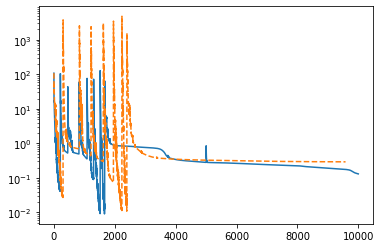

In [124]:
plt.semilogy(met_cont.scales_loss)
plt.semilogy(met_long.scales_loss, '--')

In [133]:
for k, v in normalized_error.items():
    print(f"{k}, original: {torch.pow(v, 2).mean():.03e}, continued: {torch.pow(normalized_error_cont[k], 2).mean():.03e}, long: {torch.pow(normalized_error_long[k], 2).mean():.03e}")

(0, 0), original: 2.760e-01, continued: 2.247e-01, long: 3.431e-01
(0, 1), original: 1.191e-01, continued: 9.660e-02, long: 2.317e-01
(0, 2), original: 1.131e-01, continued: 7.810e-02, long: 1.389e-01
(0, 3), original: 1.382e-01, continued: 1.194e-01, long: 2.517e-01
(1, 0), original: 4.011e-04, continued: 1.818e-04, long: 5.764e-04
(1, 1), original: 4.934e-04, continued: 2.271e-04, long: 2.863e-04
(1, 2), original: 5.717e-05, continued: 2.820e-05, long: 1.307e-04
(1, 3), original: 2.447e-04, continued: 2.028e-04, long: 4.138e-04
(2, 0), original: 1.110e-06, continued: 4.433e-07, long: 5.248e-07
(2, 1), original: 1.103e-06, continued: 4.956e-07, long: 4.667e-07
(2, 2), original: 7.146e-07, continued: 3.653e-07, long: 7.221e-07
(2, 3), original: 8.768e-07, continued: 3.863e-07, long: 6.161e-07
(3, 0), original: 4.162e-09, continued: 1.478e-09, long: 2.078e-09
(3, 1), original: 8.282e-09, continued: 3.944e-09, long: 4.293e-09
(3, 2), original: 3.195e-09, continued: 1.342e-09, long: 2.648

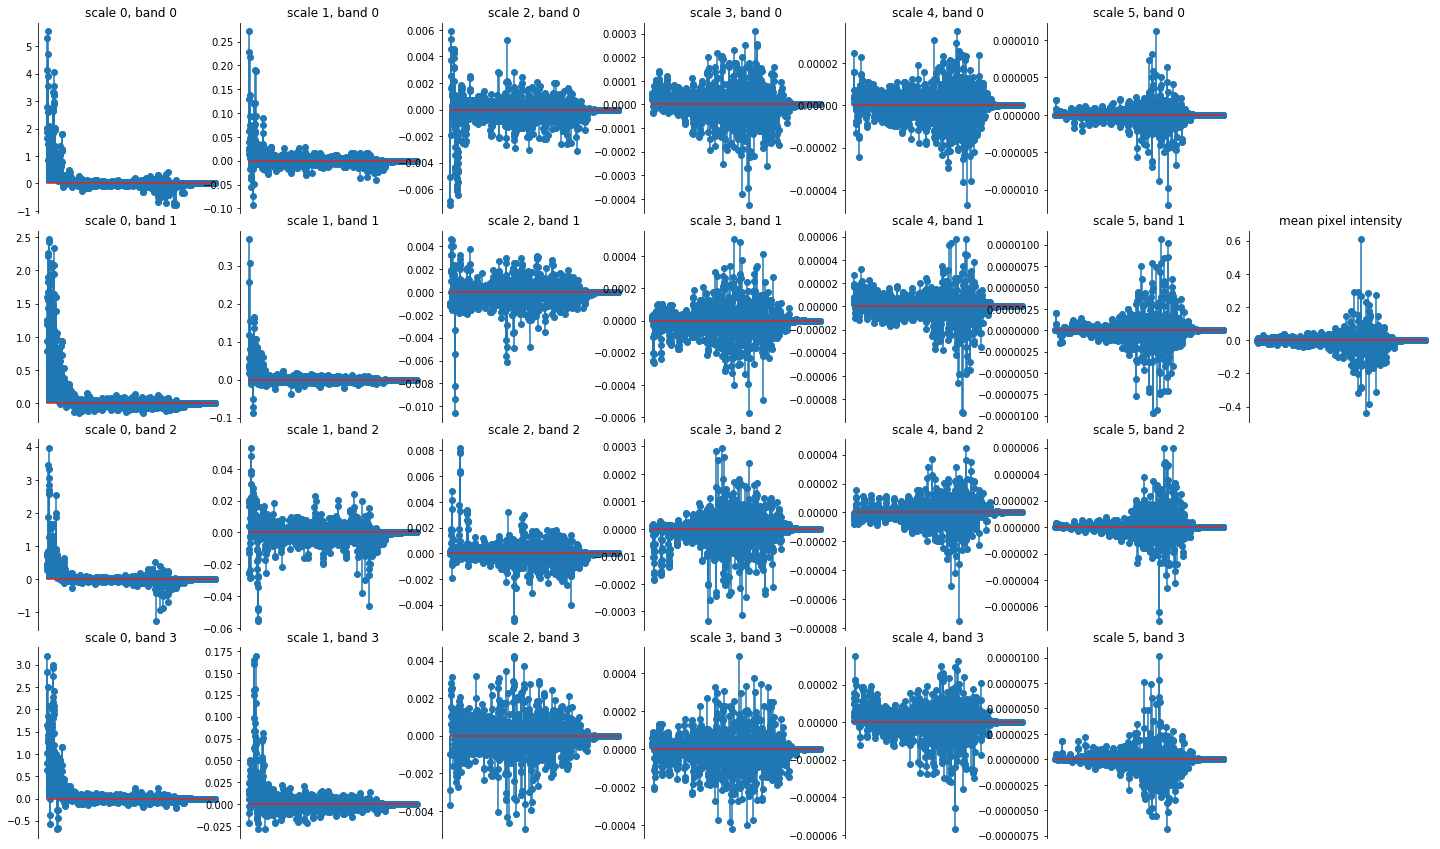

In [134]:
met.model.plot_representation(ylim=False, data=normalized_error);

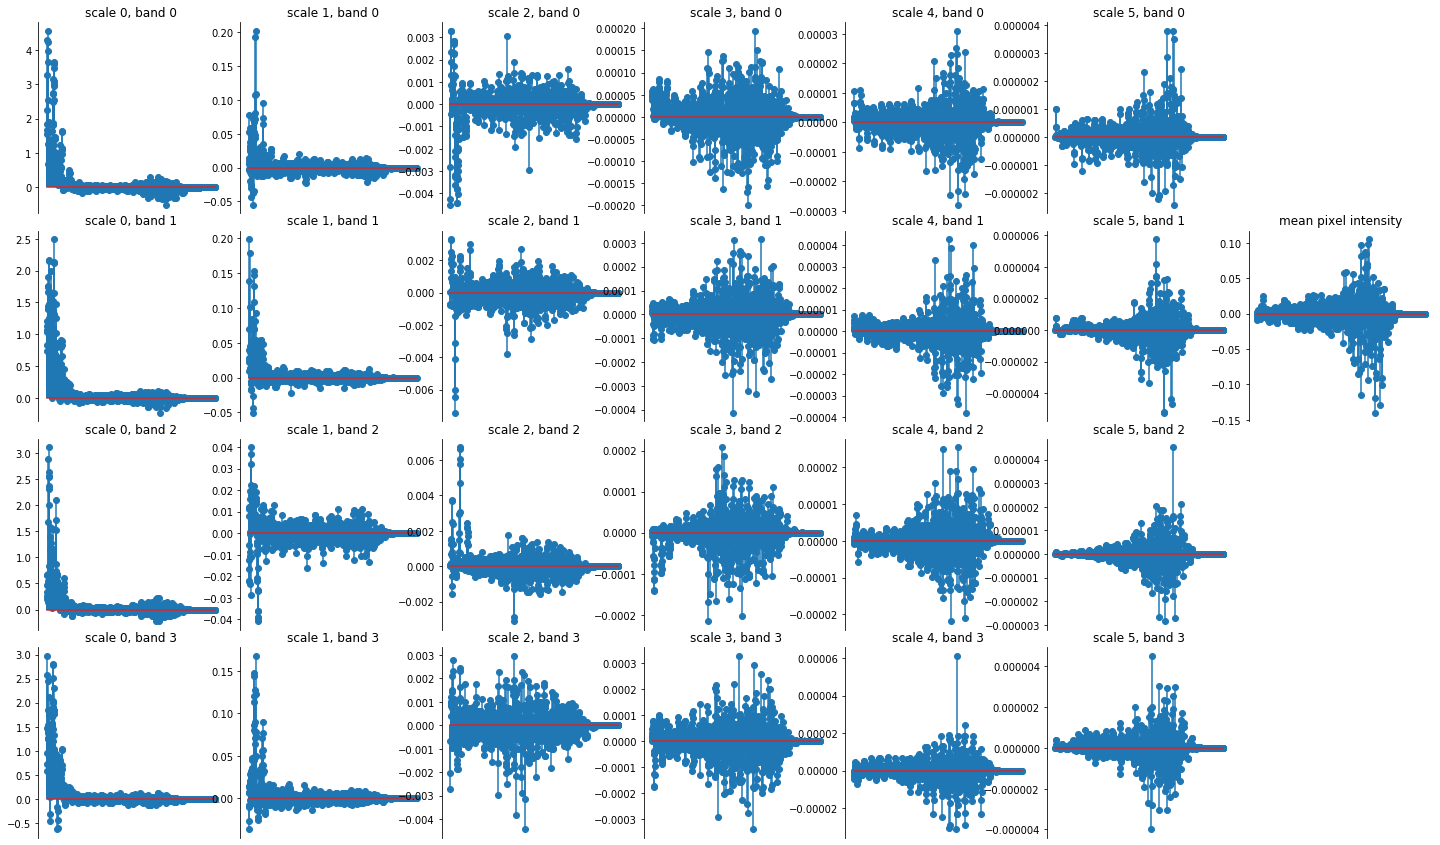

In [135]:
met.model.plot_representation(ylim=False, data=normalized_error_cont);

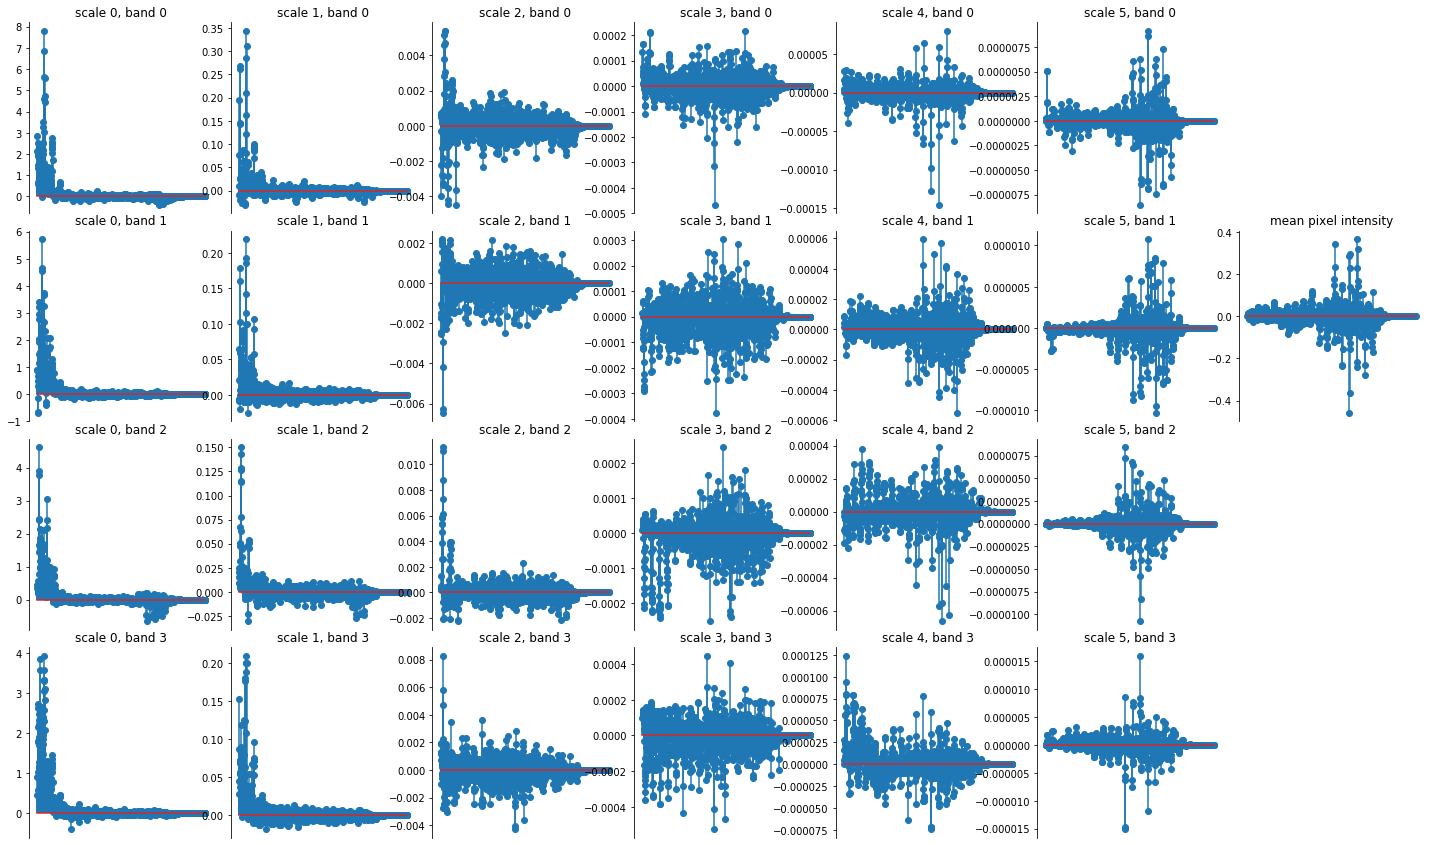

In [136]:
met.model.plot_representation(ylim=False, data=normalized_error_long);

In [67]:
met.model.normalize_dict = norm_dict

In [69]:
met.target_representation = met.model(met.target_image)

/home/billbrod/Documents/plenoptic/plenoptic/simulate/canonical_computations/non_linearities.py:454: UserWarning: stats_dict key (0.5, 0) not found in model.complex_cell_responses, skipping!
  warnings.warn("stats_dict key %s not found in model.%s, skipping!" % (l, k))
/home/billbrod/Documents/plenoptic/plenoptic/simulate/canonical_computations/non_linearities.py:454: UserWarning: stats_dict key (0.5, 1) not found in model.complex_cell_responses, skipping!
  warnings.warn("stats_dict key %s not found in model.%s, skipping!" % (l, k))
/home/billbrod/Documents/plenoptic/plenoptic/simulate/canonical_computations/non_linearities.py:454: UserWarning: stats_dict key (0.5, 2) not found in model.complex_cell_responses, skipping!
  warnings.warn("stats_dict key %s not found in model.%s, skipping!" % (l, k))
/home/billbrod/Documents/plenoptic/plenoptic/simulate/canonical_computations/non_linearities.py:454: UserWarning: stats_dict key (0.5, 3) not found in model.complex_cell_responses, skipping!

In [70]:
met.matched_representation = met.model(met.matched_image)

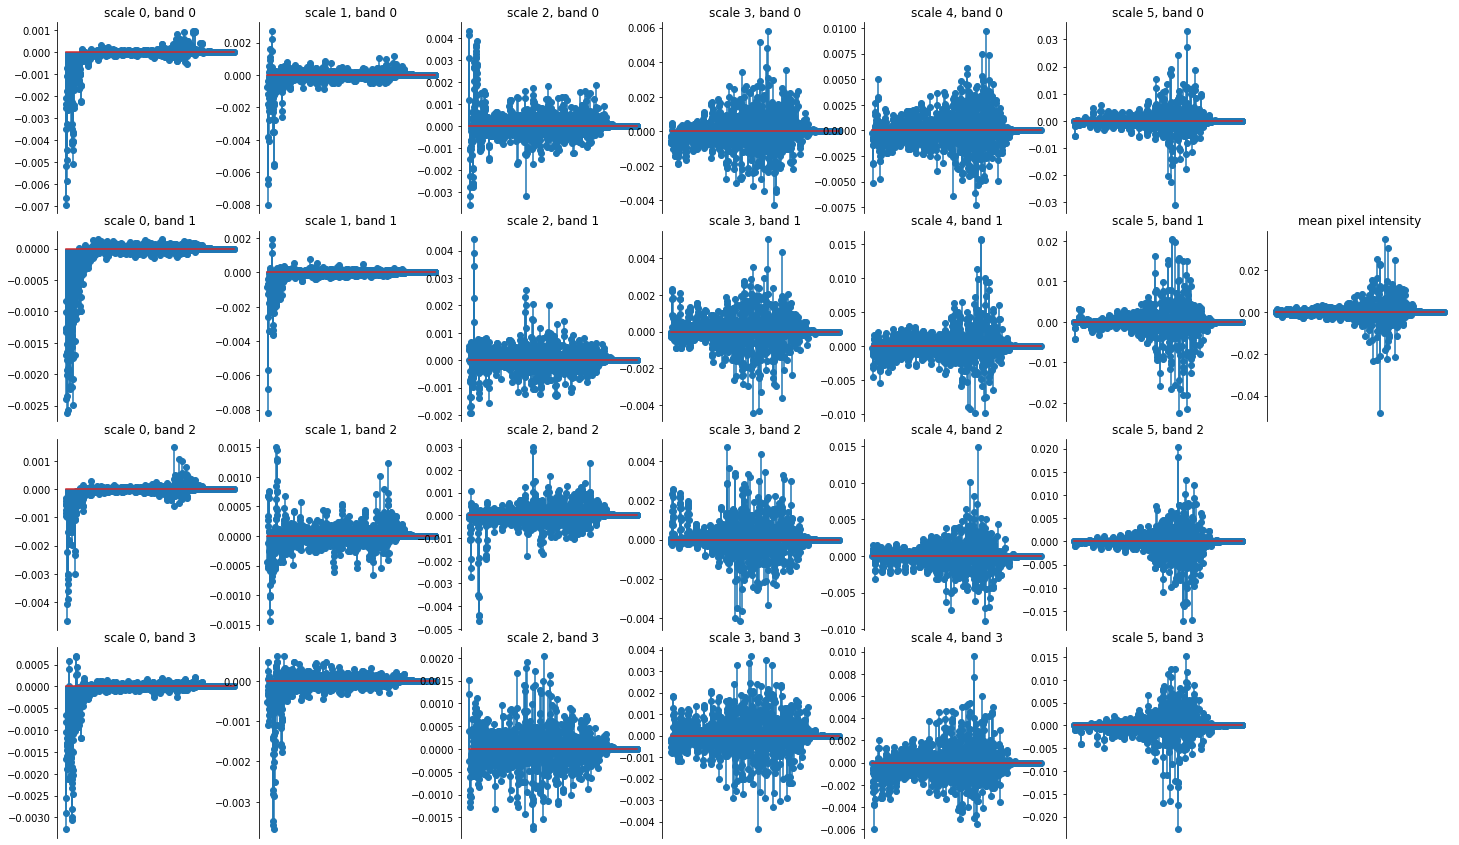

In [71]:
met.model.plot_representation(ylim=False, data=met.representation_error());

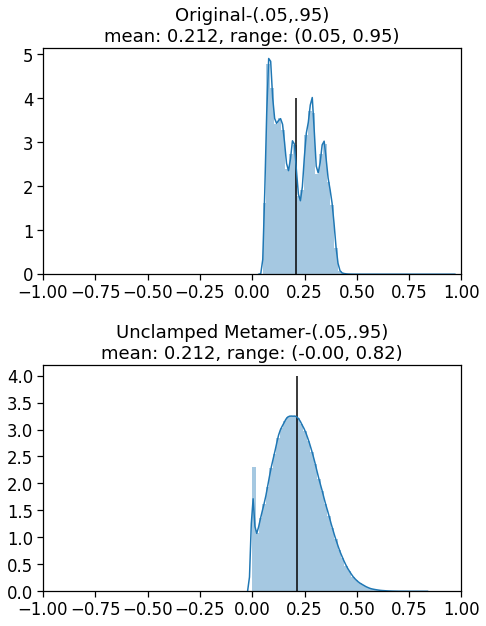

In [10]:
with sns.plotting_context('notebook', font_scale=1.5):
    fig, axes = plt.subplots(2, 1, figsize=(7.5, 10), gridspec_kw={'hspace': .4})
    for ax, d, t in zip(axes.flatten(), [met.target_image, met.matched_image], ['Original-(.05,.95)', 'Unclamped Metamer-(.05,.95)'],):
        sns.distplot(d.flatten(), ax=ax)
        ax.set(xlim=(-1, 1), title=t + f"\nmean: {d.mean():.03f}, range: ({d.min():.02f}, {d.max():.02f})")
        ax.vlines(d.mean(), 0, 4)
    #fig.savefig('/home/billbrod/Desktop/metamers/metamers/V1_cone-1.0_norm_s6_gaussian/tiles_range-.05,.95_size-1024,1024/scaling-0.5/opt-Adam/fr-0_lc-1_cf-0.01_none-False/hists.png')

# Examining RGC-gaussian metamer

In [2]:
rgc = po.simul.RetinalGanglionCells(.075, (1024, 1024), max_eccentricity=12, std_dev=1, window_type='gaussian', )
rgc = rgc.to(0)

In [7]:
img = np.array(imageio.imread('/home/billbrod/Desktop/metamers/ref_images_preproc/tiles_full_size-1024,1024.png'), dtype=np.float32)
met = np.array(imageio.imread('/home/billbrod/Desktop/metamers/metamers_display/RGC_cone-1.0_gaussian/tiles_cone_full_size-1024,1024/scaling-0.075/'
                              'opt-Adam/fr-0_lc-1_cf-0_clamp-True/seed-0_init-white_lr-0.1_e0-1.0_em-12_iter-750_thresh-1e-08_gpu-1_metamer-16.png'),
               dtype=np.float32)
cone = np.array(imageio.imread('/home/billbrod/Desktop/metamers/ref_images_preproc/tiles_cone_full_size-1024,1024.png'), dtype=np.float32)
cone_met = np.array(imageio.imread('/home/billbrod/Desktop/metamers/metamers/RGC_cone-1.0_gaussian/tiles_cone_full_size-1024,1024/scaling-0.075/'
                                   'opt-Adam/fr-0_lc-1_cf-0_clamp-True/seed-0_init-white_lr-0.1_e0-1.0_em-12_iter-750_thresh-1e-08_gpu-1_metamer-16.png'),
                    dtype=np.float32)
img = torch.tensor(img / np.iinfo(np.uint16).max, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
met = torch.tensor(met / np.iinfo(np.uint16).max, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
cone = torch.tensor(cone / np.iinfo(np.uint16).max, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
cone_met = torch.tensor(cone_met / np.iinfo(np.uint16).max, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

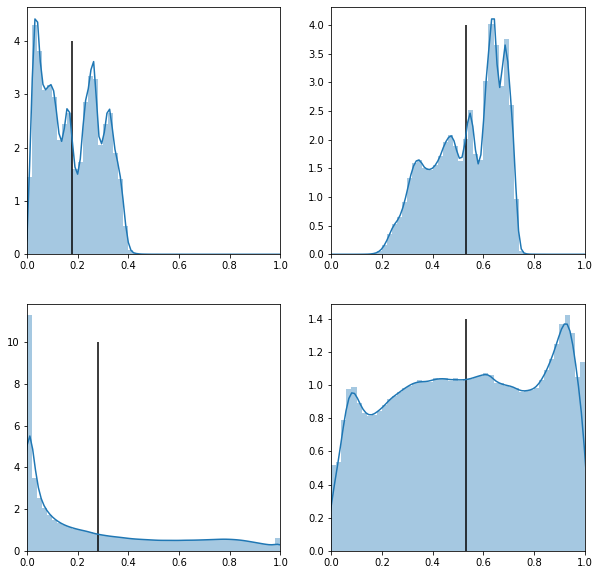

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for ax, d, m in zip(axes.flatten(), [img, cone, met, cone_met], [4, 4, 10, 1.4]):
    sns.distplot(d.flatten(), ax=ax);
    ax.vlines(d.mean(), 0, m)
    ax.set(xlim=(0, 1))

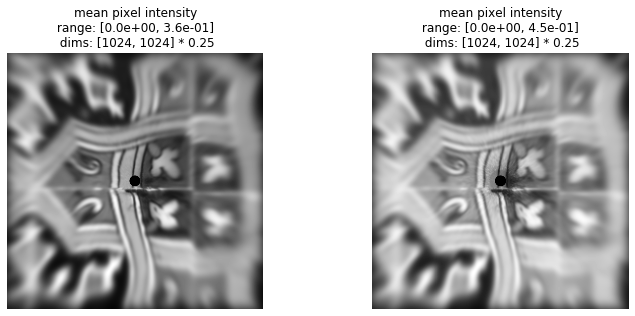

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
rgc(img);
rgc.plot_representation_image(zoom=.25, ax=axes[0]);
rgc(met);
rgc.plot_representation_image(zoom=.25, ax=axes[1]);

In [16]:
img_rep = rgc(img).reshape((rgc.n_eccentricity_bands, rgc.n_polar_windows))
met_rep = rgc(met).reshape((rgc.n_eccentricity_bands, rgc.n_polar_windows))

In [18]:
rgc.representation

tensor([[[0.0718, 0.0985, 0.0953,  ..., 0.0000, 0.0000, 0.0000]]],
       device='cuda:0')

In [20]:
met_rep.shape

torch.Size([116, 395])

In [ ]:
'hi'

In [ ]:
met_rep[:, 0]

In [5]:
img = np.array(imageio.imread('/home/billbrod/Desktop/metamers/ref_images_preproc/tiles_range-.05,.95_size-1024,1024.png'), dtype=np.float32)
met = np.array(imageio.imread('/home/billbrod/Desktop/metamers/metamers_display/RGC_cone-1.0_gaussian/tiles_range-.05,.95_size-1024,1024/scaling-0.075/'
                              'opt-Adam/fr-0_lc-1_cf-0_clamp-True/seed-0_init-white_lr-0.1_e0-1.0_em-12_iter-750_thresh-1e-08_gpu-1_metamer-16.png'),
               dtype=np.float32)
img = torch.tensor(img / np.iinfo(np.uint16).max, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
met = torch.tensor(met / np.iinfo(np.uint16).max, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

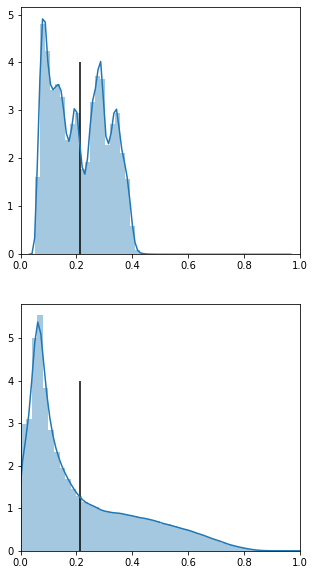

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(5, 10))
for ax, d, m in zip(axes.flatten(), [img, met,], [4, 4, ]):
    sns.distplot(d.flatten(), ax=ax);
    ax.vlines(d.mean(), 0, m)
    ax.set(xlim=(0, 1))

# DoG Testing

In [29]:
rgc = po.simul.RetinalGanglionCells(.075, (1024, 1024), window_type='dog', std_dev=1, surround_std_dev=2, min_eccentricity=None, 
                                    transition_x=1, center_surround_ratio=.5, )#cache_dir='/home/billbrod/Desktop/windows_cache')
rgc = rgc.to(1)

In [20]:
# ones = torch.ones((1, 1, 1024, 1024))
img = imageio.imread('/home/billbrod/Desktop/metamers/ref_images_preproc/')
# img = torch.tensor(img/np.iinfo(img.dtype).max, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

In [22]:
a, b = re.findall('range-([.0-9]+),([.0-9]+)', 'thisis_a_test_range-.05,.95_ts')[0]
a = float(a)
b = float(b)

In [23]:
img = img * (b - a) + a

In [26]:
img.min()

0.05

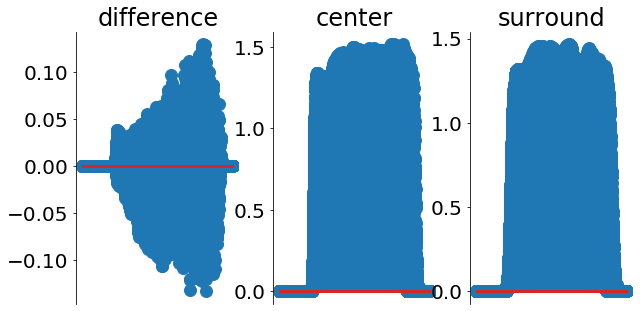

In [32]:
rgc(img);
rgc.plot_representation(ylim=False,);

In [53]:
met = po.synth.Metamer(img, rgc)

In [ ]:
met.synthesize(store_progress=True, optimizer='Adam', learning_rate=.1, );

In [21]:
met = met.to('cpu')

/home/billbrod/Documents/plenoptic/plenoptic/tools/display.py:378: UserWarning: ax is not None, so we're ignoring figsize...
  warnings.warn("ax is not None, so we're ignoring figsize...")
/home/billbrod/Documents/plenoptic/plenoptic/simulate/models/ventral_stream.py:941: UserWarning: ax is not None, so we're ignoring figsize...
  warnings.warn("ax is not None, so we're ignoring figsize...")


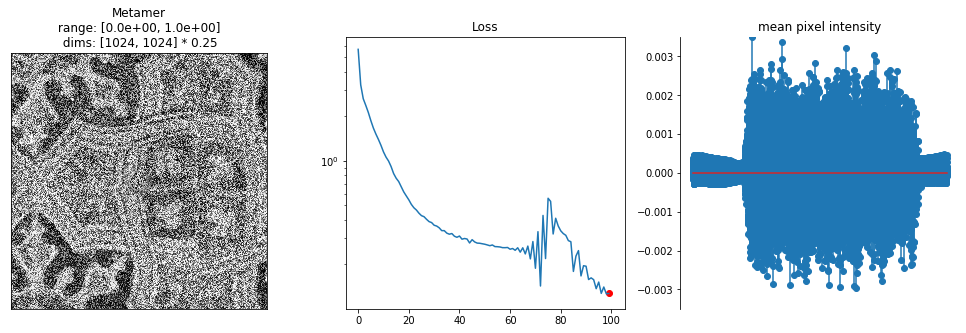

In [22]:
met.plot_metamer_status(imshow_zoom=.25);

In [8]:
rgc(ones)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')

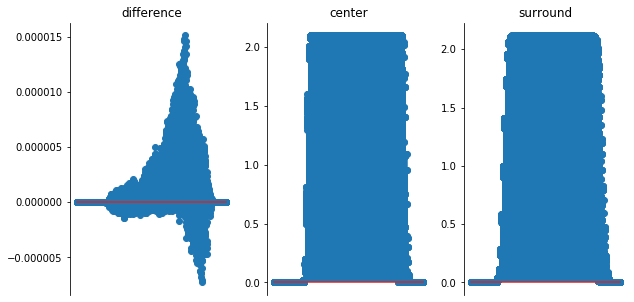

In [9]:
rgc.plot_representation(ylim=False);

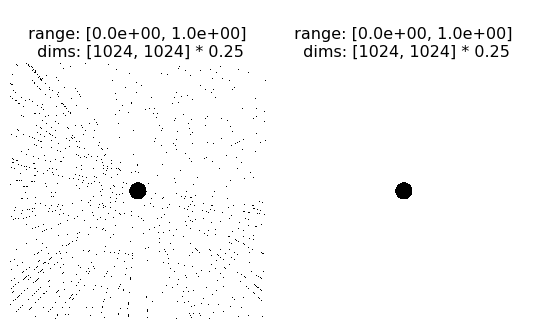

In [23]:
imgs = [rgc.PoolingWindows.project_dog(ones, ones_flag=True).to(bool), 
        rgc.PoolingWindows.project(rgc.PoolingWindows.forward(ones, windows_key='center'), windows_key='center').to(bool)]
pt.imshow([po.to_numpy(x.squeeze()) for x in imgs], zoom=.25);

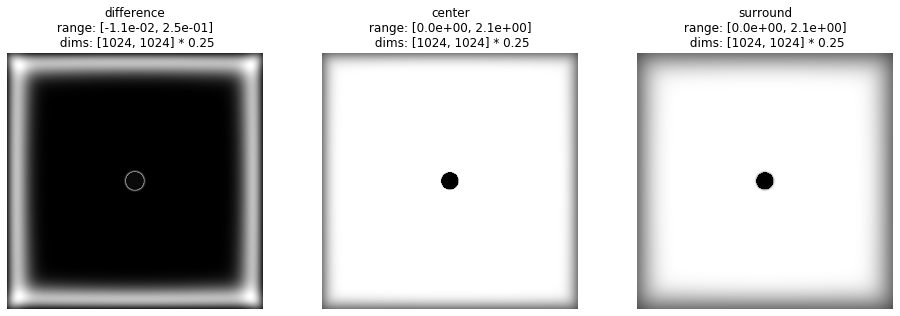

In [11]:
rgc.plot_representation_image(figsize=(16, 5), zoom=.25);

In [32]:
rgc_un = po.simul.RetinalGanglionCells(.1, (1024, 1024), window_type='dog', std_dev=1, surround_std_dev=2, min_eccentricity=None, 
                                    transition_x=1, center_surround_ratio=.75, )#cache_dir='/home/billbrod/Desktop/windows_cache')
rgc_un = rgc_un.to(0)

/home/billbrod/Documents/plenoptic/plenoptic/simulate/canonical_computations/pooling.py:1825: UserWarning: This will not tile correctly at the fovea, due to differences in the rate at which the sums across the center and surround windows rise to 1. The PoolingWindows object has a work-around for this, use that for any application of these windows.
  warnings.warn("This will not tile correctly at the fovea, due to differences in the rate "


In [ ]:
rgc_un(ones);

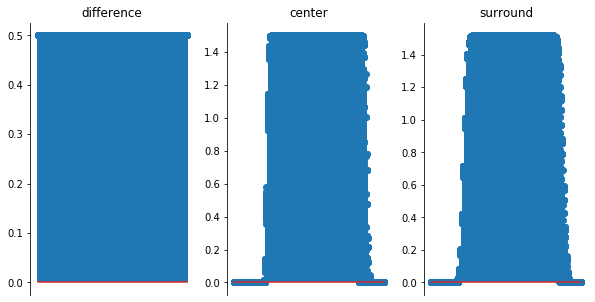

In [34]:
rgc_un.plot_representation(ylim=False);

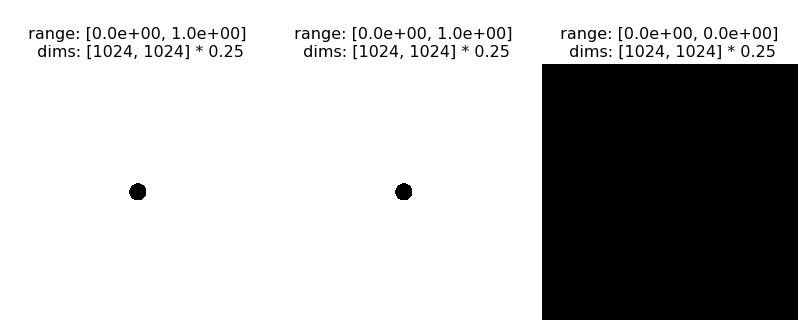

In [35]:
imgs = [rgc_un.PoolingWindows.project_dog(ones, ones_flag=True).to(bool), 
        rgc_un.PoolingWindows.project(rgc.PoolingWindows.forward(ones, windows_key='center'), windows_key='center').to(bool)]
imgs += [imgs[0].to(float) - imgs[1].to(float)]
pt.imshow([po.to_numpy(x.squeeze()) for x in imgs], zoom=.25);

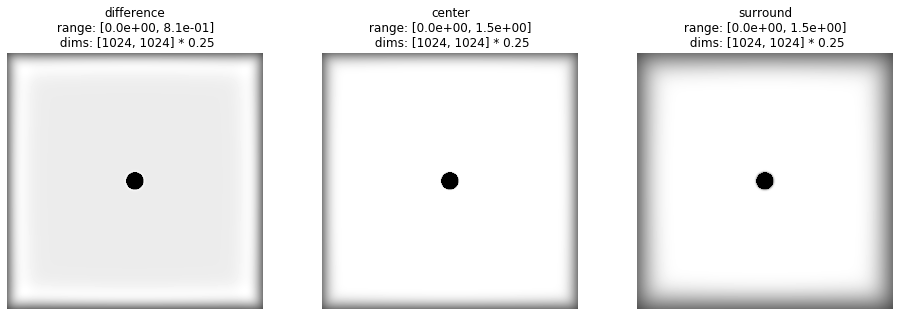

In [36]:
rgc_un.plot_representation_image(figsize=(16, 5), zoom=.25);

# Old

In [10]:
met_dog = imageio.imread('/home/billbrod/Desktop/metamers/metamers/RGC_cone-1.0_dog_s-6.0_r-0.53/tiles_cone_full_size-1024,1024/scaling-0.075/opt-Adam/fr-0_lc-1_cf-0_clamp-True/seed-0_init-white_lr-0.1_e0-1.0_em-12_iter-750_thresh-1e-08_gpu-1_metamer-16.png')
met_dog = torch.tensor(met_dog/np.iinfo(np.uint16).max, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

met = imageio.imread('/home/billbrod/Desktop/metamers/metamers/RGC_cone-1.0_gaussian/tiles_cone_full_size-1024,1024/scaling-0.075/opt-Adam/fr-0_lc-1_cf-0_clamp-True/seed-0_init-white_lr-0.1_e0-1.0_em-12_iter-750_thresh-1e-08_gpu-1_metamer-16.png')
met = torch.tensor(met/np.iinfo(np.uint16).max, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

ref = imageio.imread('/home/billbrod/Desktop/metamers/ref_images_preproc/tiles_cone_full_size-1024,1024.png')
ref = torch.tensor(ref/np.iinfo(np.uint16).max, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

met = met.to(0)
ref = ref.to(0)
met_dog = met_dog.to(0)

In [2]:
met_dog = po.synth.Metamer.load("/home/billbrod/Desktop/metamers/metamers/RGC_cone-1.0_dog_s-2.0_r-0.53/tiles_cone_full_size-1024,1024/scaling-0.075/opt-SGD/fr-0_lc-1_cf-0_clamp-True/seed-0_init-white_lr-0.1_e0-1.0_em-12_iter-750_thresh-1e-08_gpu-1.pt", po.simul.RetinalGanglionCells.from_state_dict_reduced, 'cuda:0')
met = po.synth.Metamer.load("/home/billbrod/Desktop/metamers/metamers/RGC_cone-1.0_gaussian/tiles_cone_full_size-1024,1024/scaling-0.075/opt-Adam/fr-0_lc-1_cf-0_clamp-True/seed-0_init-white_lr-0.1_e0-1.0_em-12_iter-750_thresh-1e-08_gpu-1.pt", po.simul.RetinalGanglionCells.from_state_dict_reduced, 'cuda:0')

/home/billbrod/Documents/plenoptic/plenoptic/simulate/canonical_computations/pooling.py:2226: UserWarning: Loading windows from cache: /home/billbrod/Desktop/metamers/windows_cache/scaling-0.075_size-1024,1024_e0-1.000_em-12.0_w-1.0_s-2.0_r-0.53_dog.pt
  warnings.warn("Loading windows from cache: %s" % self.cache_paths[-1])
/home/billbrod/Documents/plenoptic/plenoptic/simulate/canonical_computations/pooling.py:2226: UserWarning: Loading windows from cache: /home/billbrod/Desktop/metamers/windows_cache/scaling-0.075_size-1024,1024_e0-1.000_em-12.0_w-1.0_gaussian.pt
  warnings.warn("Loading windows from cache: %s" % self.cache_paths[-1])


In [22]:
ones = torch.ones_like(met_dog.matched_image)

(<Figure size 1080x360 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fca37dc1710>,
       dtype=object))

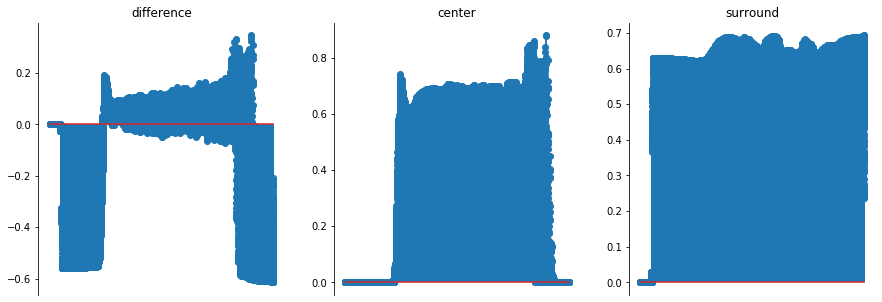

In [23]:
met_dog.model(met_dog.target_image)
met_dog.model.plot_representation((15, 5), ylim=False)

In [25]:
met_dog.saved_image.shape

torch.Size([751, 1, 1, 1024, 1024])

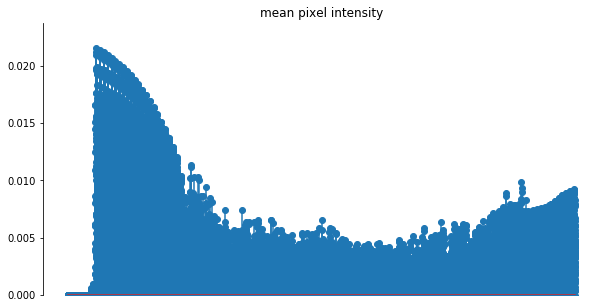

In [26]:
met_dog.model.plot_representation(data=met_dog.saved_representation_gradient[0]);

(<Figure size 720x360 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x7f6f38ec7e90>])

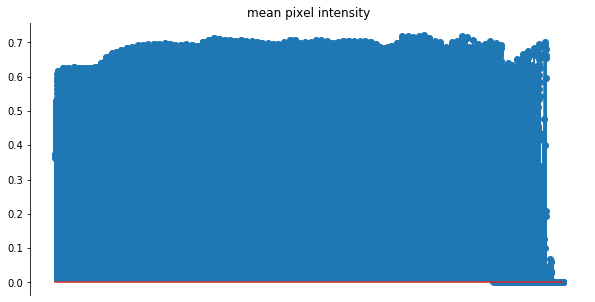

In [23]:
met.model(met_dog.target_image)
met.model.plot_representation(ylim=False)

In [50]:
rgc_dog = po.simul.RetinalGanglionCells(.075, (1024, 1024), None, window_type='dog', transition_x=1, surround_std_dev=6, std_dev=1, cache_dir='/home/billbrod/Desktop/metamers/windows_cache/', max_eccentricity=12)
rgc_dog = rgc_dog.to(0)

/home/billbrod/Documents/plenoptic/plenoptic/simulate/canonical_computations/pooling.py:2128: UserWarning: Loading windows from cache: /home/billbrod/Desktop/metamers/windows_cache/scaling-0.075_size-1024,1024_e0-1.000_em-12.0_w-1.0_s-6.0_r-0.53_dog.pt
  warnings.warn("Loading windows from cache: %s" % self.cache_paths[-1])


In [51]:
rgc = po.simul.RetinalGanglionCells(.075, (1024, 1024), window_type='gaussian', std_dev=1, min_eccentricity=1, cache_dir='/home/billbrod/Desktop/metamers/windows_cache/', max_eccentricity=15)
rgc = rgc.to(0)

/home/billbrod/Documents/plenoptic/plenoptic/simulate/canonical_computations/pooling.py:2128: UserWarning: Loading windows from cache: /home/billbrod/Desktop/metamers/windows_cache/scaling-0.075_size-1024,1024_e0-1.000_em-15.0_w-1.0_gaussian.pt
  warnings.warn("Loading windows from cache: %s" % self.cache_paths[-1])


(<Figure size 720x360 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x7ff77f0c0e10>])

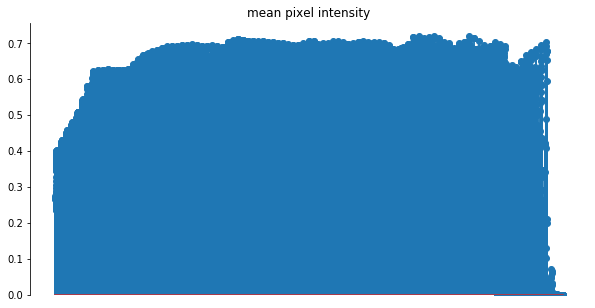

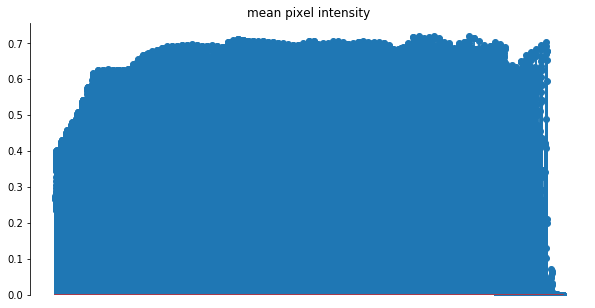

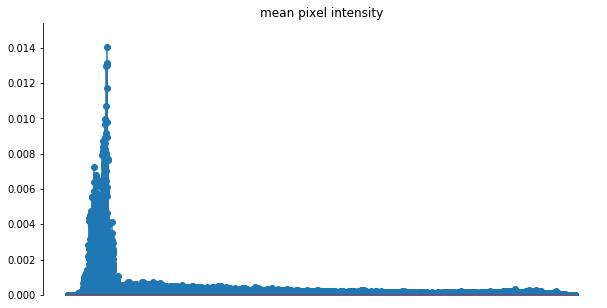

In [115]:
rgc(met)
rgc.plot_representation()
rgc(ref)
rgc.plot_representation()
rgc.plot_representation(data=rgc(ref)-rgc(met))

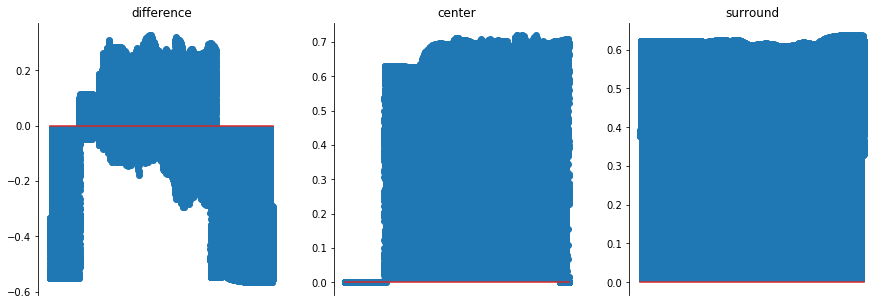

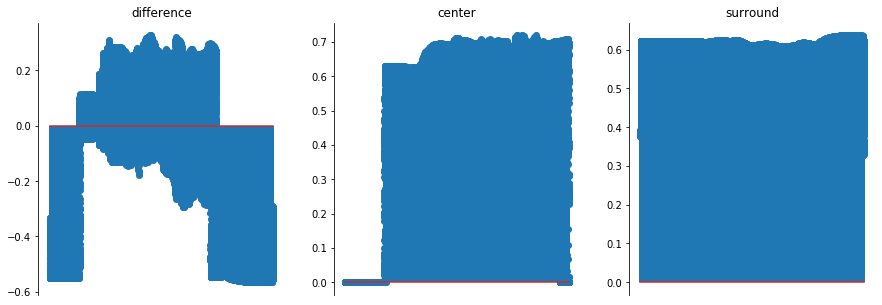

In [116]:
met_rep = rgc_dog(met_dog)
rgc_dog.plot_representation(figsize=(15, 5), ylim=False);
ref_rep = rgc_dog(ref)
rgc_dog.plot_representation(figsize=(15, 5), ylim=False);

(<Figure size 1080x360 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff77a3ffd50>,
       dtype=object))

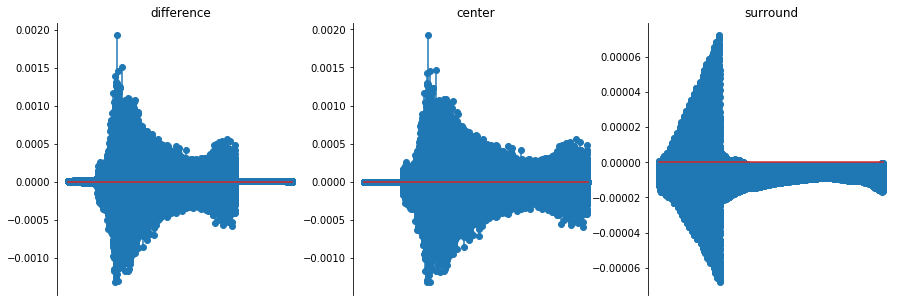

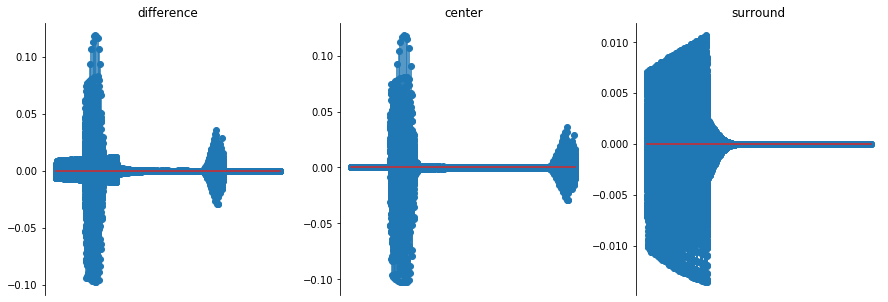

In [113]:
rgc_dog(met_dog - ref)
rgc_dog.plot_representation(figsize=(15, 5), ylim=False)
rgc_dog(met - ref)
rgc_dog.plot_representation(figsize=(15, 5), ylim=False)

In [57]:
met2 = imageio.imread('/home/billbrod/Desktop/metamers/metamers_display/RGC_cone-1.0_dog_s-2.0_r-0.53/tiles_cone_full_size-1024,1024/scaling-0.075/opt-Adam/fr-0_lc-1_cf-0_clamp-True/seed-0_init-white_lr-0.1_e0-1.0_em-12_iter-750_thresh-1e-08_gpu-1_metamer.png')
met_good = imageio.imread('/home/billbrod/Desktop/metamers/metamers_display/RGC_cone-1.0_gaussian/tiles_cone_full_size-1024,1024/scaling-0.075/opt-Adam/fr-0_lc-1_cf-0_clamp2-True/seed-0_init-white_lr-0.1_e0-1.0_em-12_iter-750_thresh-1e-08_gpu-1_metamer.png')
met_gauss = imageio.imread('/home/billbrod/Desktop/metamers/metamers_display/RGC_cone-1.0_gaussian/tiles_cone_full_size-1024,1024/scaling-0.075/opt-Adam/fr-0_lc-1_cf-0_clamp-True/seed-0_init-white_lr-0.1_e0-1.0_em-12_iter-750_thresh-1e-08_gpu-1_metamer.png')

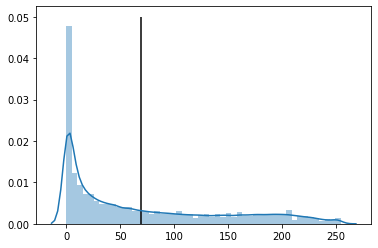

In [62]:
sns.distplot(met2.flatten())
plt.vlines(met2.mean(), 0, .05)

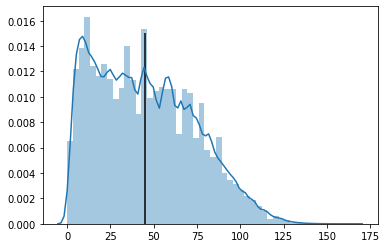

In [63]:
sns.distplot(met_good.flatten())
plt.vlines(met_good.mean(), 0, .015)

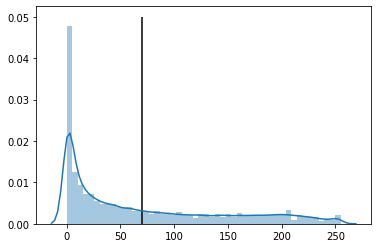

In [64]:
sns.distplot(met_gauss.flatten())
plt.vlines(met_gauss.mean(), 0, .05)

# Bandpass?

In [149]:
x = np.linspace(-15, 15, 100)
s = 1
k = 2
gc = 1/(2*np.pi*s) * np.exp(-.5*(x**2 / s))
gs = 1/(2*np.pi*(k*s)) * np.exp(-.5*(x**2 / (k*s)))

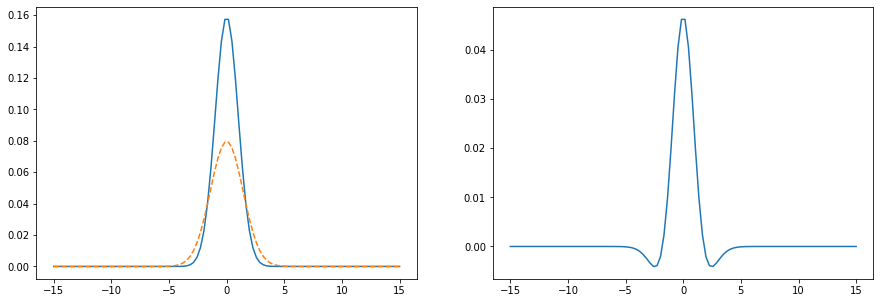

In [150]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(x, gc)
axes[0].plot(x, gs, '--')
axes[1].plot(x, .53 * gc - (1-.53)*gs)

In [2]:
ones = torch.ones((1,1,256,256), dtype=torch.float32, device=0)

In [3]:
test = po.simul.PoolingWindows(.5, (256, 256), None, window_type='dog', transition_x=1, surround_std_dev=2, std_dev=1, max_eccentricity=12, )
test = test.to(0)

/home/billbrod/Documents/plenoptic/plenoptic/simulate/canonical_computations/pooling.py:1766: UserWarning: This will not tile correctly at the fovea, due to differences in the rate at which the sums across the center and surround windows rise to 1. The PoolingWindows object has a work-around for this, use that for any application of these windows.
  warnings.warn("This will not tile correctly at the fovea, due to differences in the rate "


In [7]:
test.central_eccentricity_degrees

array([ 0.        ,  0.21017866,  0.42035732,  0.63053596,  0.84071463,
        1.0522106 ,  1.298321  ,  1.6019964 ,  1.9767008 ,  2.4390485 ,
        3.0095382 ,  3.7134643 ,  4.582038  ,  5.6537704 ,  6.9761786 ,
        8.607896  , 10.621269  , 13.105568  , 16.170942  , 19.9533    ,
       24.620348  , 30.379015  , 37.48461   , 46.252213  , 57.07052   ],
      dtype=float32)

In [6]:
test.angle_windows['center'][0]

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.3780e-13,
          1.8349e-13, 2.4343e-13],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.8308e-13,
          2.4343e-13, 3.2250e-13],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.4343e-13,
          3.2322e-13, 4.2758e-13],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.4343e-13,
          3.2322e-13, 4.2758e-13],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.8308e-13,
          2.4343e-13, 3.2250e-13],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.3780e-13,
          1.8349e-13, 2.4343e-13]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.2867e-17,
          5.9283e-17, 8.1663e-17],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 5.9133e-17,
          8.1663e-17, 1.1233e-16],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 8.1663e-17,
          1.1262e-16, 1.5469e-16],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.6695e-10,
          3.412

In [16]:
test = po.simul.RetinalGanglionCells(.5, (256, 256), None, window_type='dog', transition_x=1, surround_std_dev=2, std_dev=1, max_eccentricity=12, )

/home/billbrod/Documents/plenoptic/plenoptic/simulate/canonical_computations/pooling.py:1766: UserWarning: This will not tile correctly at the fovea, due to differences in the rate at which the sums across the center and surround windows rise to 1. The PoolingWindows object has a work-around for this, use that for any application of these windows.
  warnings.warn("This will not tile correctly at the fovea, due to differences in the rate "


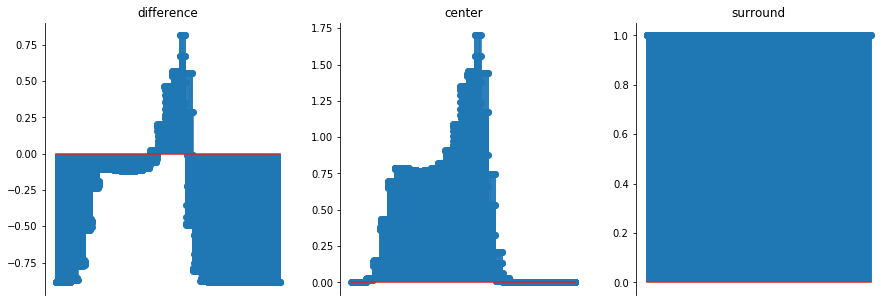

In [17]:
test(ones)
test.plot_representation((15, 5), ylim=False);

(<Figure size 1152x360 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fca3a063d50>,
       dtype=object))

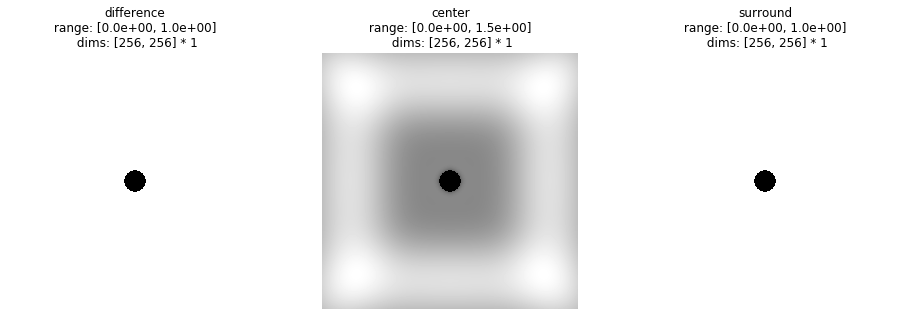

In [18]:
test.plot_representation_image((16, 5))

In [154]:
test.representation[..., 0]

tensor([[-0.8867]], device='cuda:0')

In [155]:
test.center_representation[...,0]

tensor([[1.2872e-06]], device='cuda:0')

In [157]:
test.PoolingWindows.window_sizes['center']

{0: tensor([1.2872e-06, 1.7311e-06, 2.6696e-06,  ..., 1.0000e-35, 1.0000e-35,
         1.0000e-35], device='cuda:0')}

In [156]:
test.surround_representation[...,0]

tensor([[0.0277]], device='cuda:0')

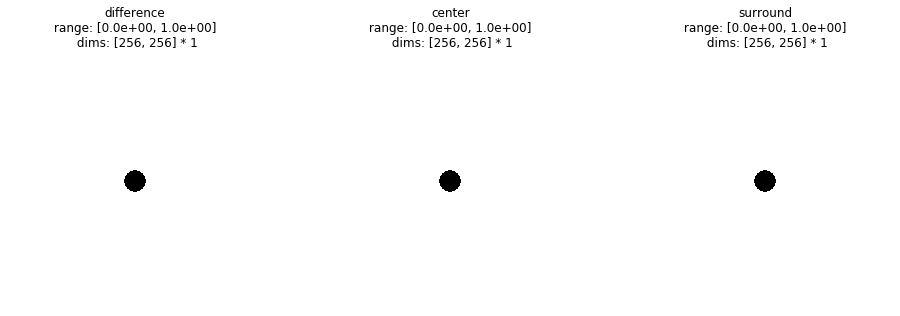

In [143]:
test.plot_representation_image((16, 5));

In [114]:
a, e, s = test.angle_windows.copy(), test.ecc_windows.copy(), test.window_sizes.copy()

In [130]:
s['center'] = s['center'][0].unsqueeze(1).unsqueeze(2)
s['surround'] = s['surround'][0].unsqueeze(1).unsqueeze(2)

In [119]:
windows = dict((k, torch.einsum('ahw,ehw->eahw', a[k][0], e[k][0]).flatten(0, 1)) for k in ['center', 'surround'])

In [183]:
dog = (test.center_surround_ratio * windows['center'] - (1-test.center_surround_ratio)*windows['surround'] ) / (s['surround'])

In [188]:
test(ones)

tensor([[[-0.8867, -0.8867, -0.8867,  ..., -0.8868, -0.8868, -0.8868]]],
       device='cuda:0')

In [189]:
torch.einsum('bchw,ahw->bca', ones, dog) / test.center_surround_ratio

tensor([[[-0.8867, -0.8867, -0.8867,  ..., -0.8868, -0.8868, -0.8868]]],
       device='cuda:0')

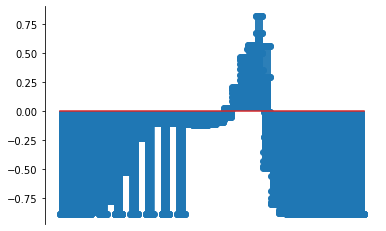

In [190]:
po.tools.display.clean_stem_plot((torch.einsum('bchw,ahw->bca', ones, dog) / test.center_surround_ratio).cpu().squeeze(), ylim=False)

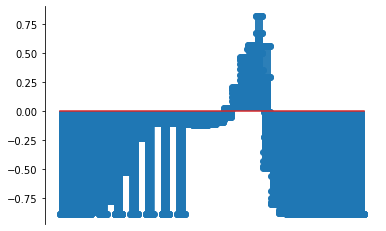

In [191]:
po.tools.display.clean_stem_plot((torch.einsum('bchw,ahw->bca', ones, dog) / test.center_surround_ratio).cpu().squeeze(), ylim=False)

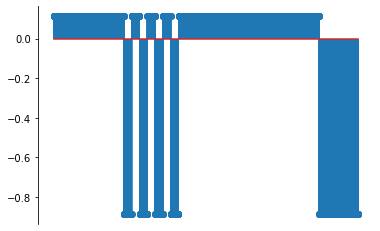

In [136]:
po.tools.display.clean_stem_plot((test(ones)).cpu().squeeze(), ylim=False)

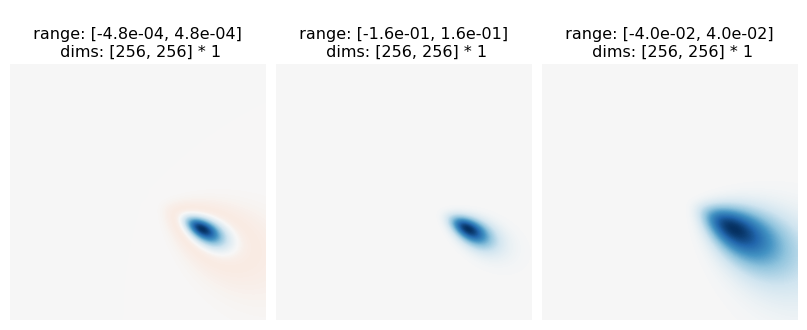

In [137]:
i = 1325
pt.imshow([dog[i].cpu().squeeze(), windows['center'][i].cpu().squeeze(), windows['surround'][i].cpu().squeeze()], vrange='indep0');

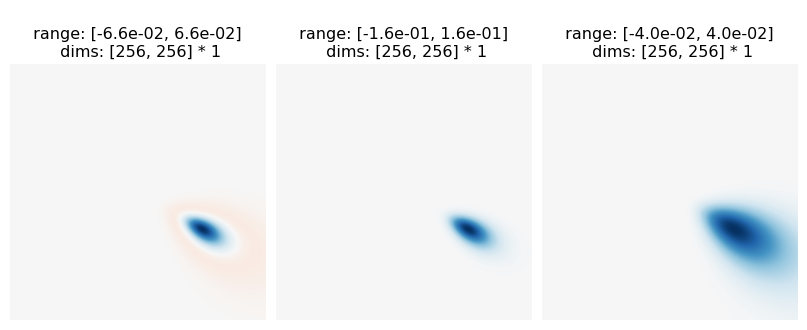

In [119]:
i = 1325
pt.imshow([dog[i].cpu().squeeze(), windows['center'][i].cpu().squeeze(), windows['surround'][i].cpu().squeeze()], vrange='indep0');

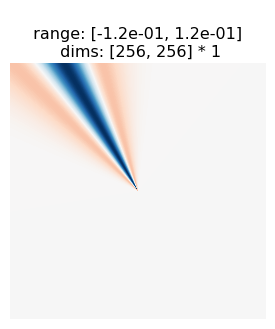

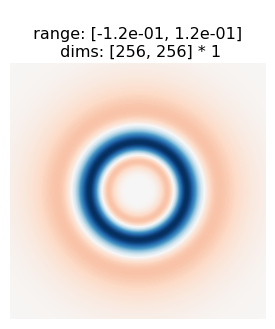

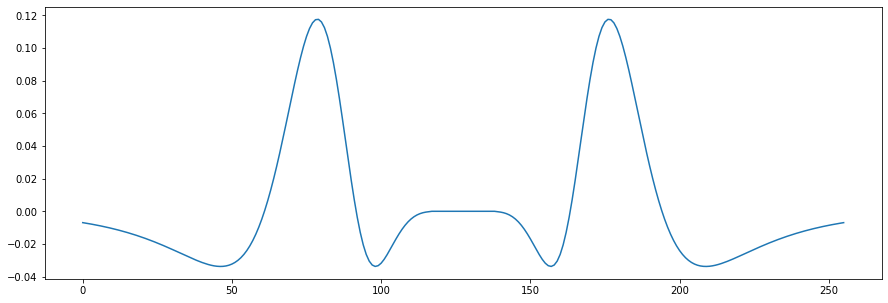

In [111]:
i = 40
pt.imshow([test.center_surround_ratio* a['center'][0][i].cpu().squeeze() - (1-test.center_surround_ratio)*a['surround'][0][i].cpu().squeeze()], vrange='indep0', zoom=1);
i = 20
pt.imshow([test.center_surround_ratio*e['center'][0][i].cpu().squeeze() - (1-test.center_surround_ratio)* e['surround'][0][i].cpu().squeeze()], vrange='indep0', zoom=1);
plt.figure(figsize=(15, 5))
plt.plot((test.center_surround_ratio*e['center'][0][i].cpu().squeeze() - (1-test.center_surround_ratio)*e['surround'][0][i].cpu().squeeze())[128]);

## 1d

In [83]:
a, e = po.simul.pooling.create_pooling_windows(.1, 256, None, 12, window_type='gaussian', transition_x=1, surround_std_dev=2, device='cpu', std_dev=1)

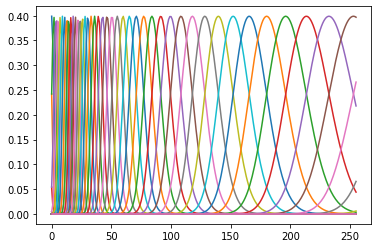

In [78]:
plt.plot(e.transpose(0, 1));

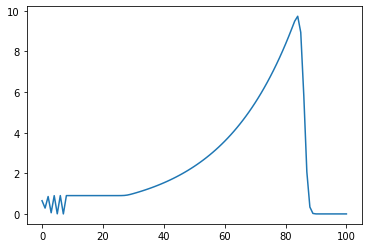

In [85]:
plt.plot((torch.norm(e, 1, 1) / 1))

In [80]:
n =torch.norm(e[w[-1]-len(w)], 1)

In [13]:
w = np.where(s==-1)[0]

In [296]:
(np.diff(idx) == 2).all()

True

In [302]:
size = torch.einsum('aw,ew->ae', a['surround'], e['surround']).flatten(0, 1)

In [304]:
size

tensor([3.2697e-01, 2.2775e-01, 3.8253e-01,  ..., 3.3487e-08, 1.6495e-09,
        6.3315e-11])

In [298]:
s.flatten()

tensor([ 1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,
         1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [270]:
size

tensor([2.3391e+00, 1.4681e+00, 3.2011e+00, 7.7042e-01, 3.9036e+00, 3.3169e-01,
        4.4421e+00, 1.1561e-01, 4.9529e+00, 3.2321e-02, 5.6182e+00, 7.1990e-03,
        6.5803e+00, 1.2714e-03, 7.9192e+00, 1.7740e-04, 9.6792e+00, 1.1905e+01,
        1.4656e+01, 1.7959e+01, 2.1675e+01, 2.5250e+01, 2.7539e+01, 2.7131e+01,
        2.3325e+01, 1.7000e+01, 1.0274e+01, 5.0664e+00, 2.0154e+00, 6.4145e-01,
        1.6239e-01, 3.2557e-02, 5.1531e-03, 6.4235e-04, 6.2943e-05, 4.8413e-06,
        2.9196e-07, 1.3792e-08, 5.0998e-10])

In [271]:
summed = sum_windows_output(size, s)
summed

tensor([2.3391e+00, 4.6692e+00, 4.6740e+00, 4.7737e+00, 5.0685e+00, 5.6505e+00,
        6.5875e+00, 7.9204e+00, 9.6794e+00, 1.1905e+01, 1.4656e+01, 1.7959e+01,
        2.1675e+01, 2.5250e+01, 2.7539e+01, 2.7131e+01, 2.3325e+01, 1.7000e+01,
        1.0274e+01, 5.0664e+00, 2.0154e+00, 6.4145e-01, 1.6239e-01, 3.2557e-02,
        5.1531e-03, 6.4235e-04, 6.2943e-05, 4.8413e-06, 2.9196e-07, 1.3792e-08,
        5.0998e-10])

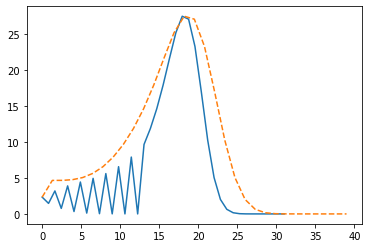

In [272]:
summed = sum_windows_output(size, s)
plt.plot(np.linspace(0, len(summed), len(size)), size)
plt.plot(np.linspace(0, len(size), len(summed)), summed, '--')

In [229]:
torch.where(s==-1)[0] + 1

tensor([ 2,  4,  6,  8, 10, 12, 14, 16])

In [227]:
idx

tensor([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
        26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38])

In [211]:
torch.where(s==-1)[0][[0, -1]]

tensor([ 1, 15])

In [223]:
slice(1, 17, 2)

slice(1, 17, 2)

In [217]:
s[1:17:2]

tensor([[-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.]])

In [203]:
(s==-1).flatten()

tensor([False,  True, False,  True, False,  True, False,  True, False,  True,
        False,  True, False,  True, False,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False])

In [195]:
e['surround'].shape

torch.Size([75, 256])

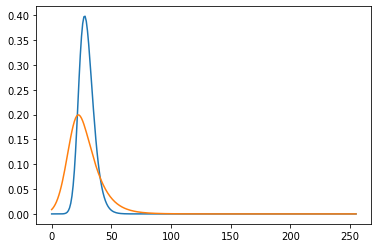

In [489]:
plt.plot(ctr[10])
plt.plot(sur[10])

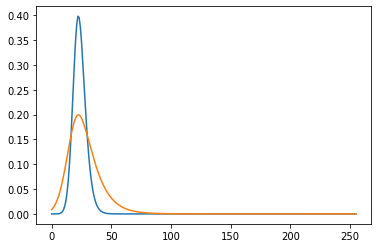

In [490]:
plt.plot(e['center'][10])
plt.plot(e['surround'][10])

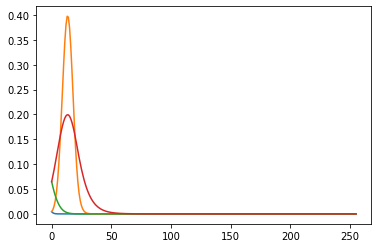

In [488]:
plt.plot(ctr[5:7].transpose(0, 1))
plt.plot(sur[5:7].transpose(0, 1));

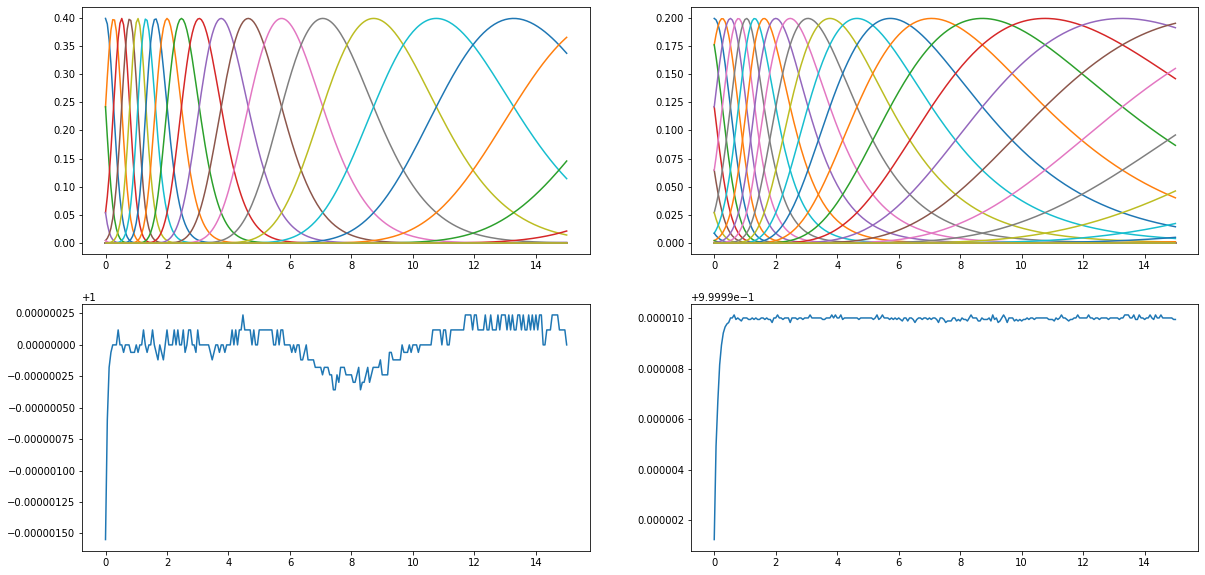

In [267]:
e = np.linspace(0, 15, 256)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes[0, 0].plot(e, ctr.transpose(0, 1));
axes[0, 1].plot(e, sur.transpose(0, 1));
axes[1, 0].plot(e, ctr.sum(0))
axes[1, 1].plot(e, sur.sum(0))

In [361]:
a = torch.tensor([1, 1, 2, 2, 3, 3, 4, 5, 6])

In [347]:
a

tensor([0, 0, 0, 0, 0, 0, 0, 0, 6])

In [359]:
np.where(~np.diff(a).astype(bool))

(array([0, 2, 4]),)

In [362]:
a[np.where(~np.diff(a).astype(bool))] = 0

In [363]:
a

tensor([0, 1, 0, 2, 0, 3, 4, 5, 6])

tensor([[ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.]])
tensor([[-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.]])
tensor([[ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        

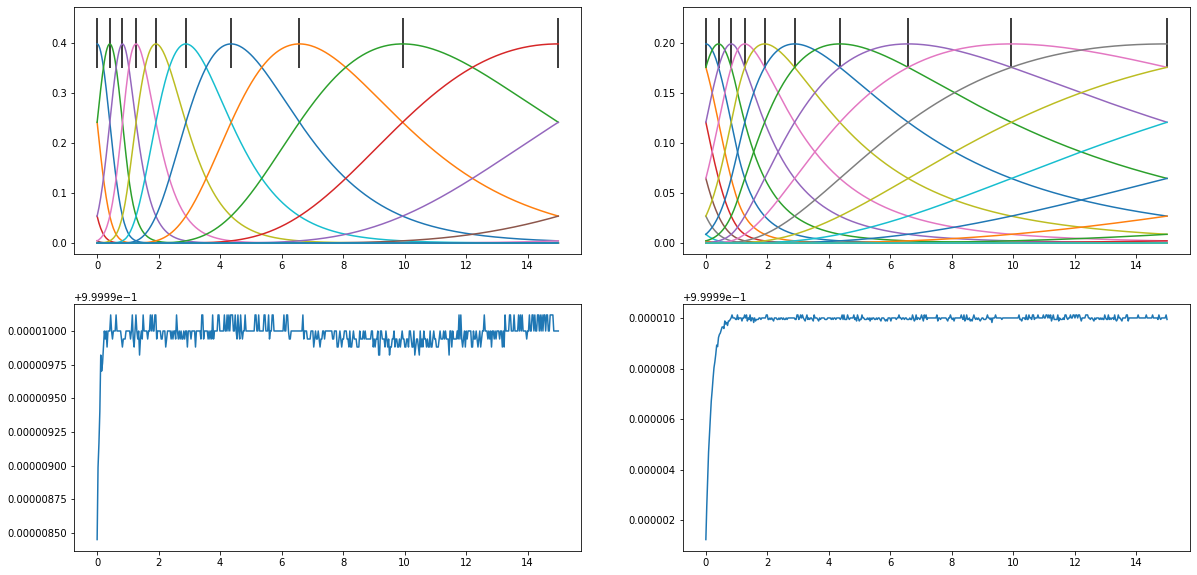

In [374]:
e = np.linspace(0, 15, 1024//2)
n_windows = 10

w1 = po.simul.pooling.log_eccentricity_windows(len(e), n_windows, min_ecc=None, window_type='gaussian', std_dev=1, transition_x=1)
w2 = po.simul.pooling.log_eccentricity_windows(len(e), n_windows, min_ecc=None, window_type='gaussian', std_dev=2, transition_x=1)
c =po.simul.pooling.calc_windows_eccentricity('central', n_windows, po.simul.pooling.calc_eccentricity_window_spacing(None, 15, n_windows, std_dev=1, transition_x=1), 1, std_dev=1, transition_x=1)

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes[0, 0].plot(e, w1.transpose(0, 1));
axes[0, 0].vlines(c, .35, .45)
axes[0, 1].plot(e, w2.transpose(0, 1));
axes[1, 0].plot(e, w1.sum(0))
axes[0, 1].vlines(c, .35/2, .45/2)
axes[1, 1].plot(e, w2.sum(0))

# In progress

In [19]:
def convert_im_to_int(im, dtype=np.uint8):
    if im.max() > 1:
        if im.max() - 1 < 1e-4:
            warnings.warn("There was a precision/rounding error somewhere and im.max is "
                          f"{im.max()}. Setting that to 1 and converting anyway")
            im = np.clip(im, 0, 1)
        else:
            raise Exception("all values of im must lie between 0 and 1, but max is %s" % im.max())
    return (im * np.iinfo(dtype).max).astype(dtype)

In [88]:
import foveated_metamers as fov